In [2]:
library(GEOquery)
library(limma)
library(umap)
library(NMF)
library(ggfortify)
library(dplyr)

In [3]:
hmr2_gene_file = '/home/akansha/downloads/metabolic_characterization/HMRdatabase2_00.xlsx - GENES.csv'
hmr2_genes = read.csv(hmr2_gene_file)
hmr2_genes <- unique(hmr2_genes$SHORT.NAME)
length(hmr2_genes)

[1] 3725

In [5]:
# load series and platform data from GEO
Sys.setenv("VROOM_CONNECTION_SIZE" = 131072 * 4)

gset <- getGEO("GSE17025", GSEMatrix =TRUE, AnnotGPL=TRUE)
if (length(gset) > 1) idx <- grep("GPL96", attr(gset, "names")) else idx <- 1
gset <- gset[[idx]]

Found 1 file(s)

GSE17025_series_matrix.txt.gz

Rows: 54675 Columns: 104
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr   (1): ID_REF
dbl (103): GSM425837, GSM425838, GSM425839, GSM425840, GSM425841, GSM425842,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
File stored at: 

/tmp/RtmpTcZpdN/GPL570.annot.gz

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”


In [6]:
# make proper column names to match toptable 
fvarLabels(gset) <- make.names(fvarLabels(gset))

# gset 
print(dim(exprs(gset)))
print(dim(pData(gset)))
colnames(pData(gset))

[1] 54675   103
[1] 103  43


[1] "title"                   "geo_accession"          
 [3] "status"                  "submission_date"        
 [5] "last_update_date"        "type"                   
 [7] "channel_count"           "source_name_ch1"        
 [9] "organism_ch1"            "characteristics_ch1"    
[11] "characteristics_ch1.1"   "characteristics_ch1.2"  
[13] "characteristics_ch1.3"   "characteristics_ch1.4"  
[15] "treatment_protocol_ch1"  "growth_protocol_ch1"    
[17] "molecule_ch1"            "extract_protocol_ch1"   
[19] "label_ch1"               "label_protocol_ch1"     
[21] "taxid_ch1"               "hyb_protocol"           
[23] "scan_protocol"           "description"            
[25] "data_processing"         "platform_id"            
[27] "contact_name"            "contact_email"          
[29] "contact_phone"           "contact_department"     
[31] "contact_institute"       "contact_address"        
[33] "contact_city"            "contact_state"          
[35] "contact_zip/postal_code" "contact_country"        
[37] "supplementary_file"      "data_row_count"         
[39] "age (years):ch1"         "grade:ch1"              
[41] "histology:ch1"           "race:ch1"               
[43] "stage:ch1"

In [7]:
colnames(pData(gset))[40] <- "grade"
colnames(pData(gset))[41] <- "histology"

In [8]:
table(gset$'grade')


  1   2   3 n/a 
 30  36  25  12 

In [9]:
table(gset$"histology")


                 atrophic endometrium     cystic atrophy with sessile polyp 
                                    3                                     1 
                         endometrioid                  inactive endometrium 
                                   79                                     5 
                     papillary serous                 secretory endometrium 
                                   12                                     2 
weakly proliferative w/cystic changes 
                                    1 

In [10]:
ex <- exprs(gset)

# log2 transform
qx <- as.numeric(quantile(ex, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
LogC <- (qx[5] > 100) || (qx[6]-qx[1] > 50 && qx[2] > 0)
if (LogC) { ex[which(ex <= 1)] <- NaN
  ex <- log2(ex) }

In [11]:
tumor_samples_id <- rownames(filter(pData(gset), grade != "n/a"))
tumor_exp <- as.data.frame(ex[, tumor_samples_id])
print(dim(tumor_exp))

# Remove nan values 
tumor_exp <- na.omit(tumor_exp)

print(dim(tumor_exp))
head(tumor_exp, 4)

[1] 54675    91
[1] 52628    91


,GSM425837,GSM425838,GSM425839,GSM425840,GSM425841,GSM425842,GSM425843,GSM425844,GSM425845,GSM425846,⋯,GSM425918,GSM425919,GSM425920,GSM425921,GSM425922,GSM425923,GSM425924,GSM425925,GSM425926,GSM425927
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1007_s_at,11.063395,8.964341,11.242162,10.328338,11.350663,10.989536,10.924887,11.550458,10.999084,11.373898,⋯,10.953396,12.489798,12.219804,11.473148,12.446127,11.183883,11.750540,11.468726,10.770664,11.021535
1053_at,7.800900,7.986411,7.036723,9.708049,8.011227,9.471675,9.208478,6.630813,8.531381,8.704250,⋯,9.450799,8.294621,8.048759,6.309249,7.439623,7.219169,7.356672,8.153805,7.057450,9.354911
117_at,7.534497,7.029011,7.922436,6.432959,6.490249,6.341630,6.998872,7.327328,6.551516,8.358871,⋯,8.006186,4.432959,4.263034,7.775446,6.068241,7.073606,7.669594,7.920651,7.658926,6.943687
121_at,11.256563,14.587660,13.757838,13.428949,14.487488,12.600749,13.858243,9.936343,12.701090,13.842399,⋯,14.447710,13.649413,13.921980,15.519123,15.478419,14.341408,13.881171,14.349931,15.080709,13.400653


In [12]:
apply(is.na(tumor_exp), 1, which)

integer(0)

In [13]:
# Check if dataframe has negative values or not
# tumor_exp[tumor_exp<0,]
has.neg <- apply(tumor_exp, 1, function(row) any(row < 0))
print(which(has.neg))

named integer(0)


### Mapping

In [14]:
dir_n <- '/home/akansha/downloads/metabolic_characterization/met_subtypes_nmf/ucec_nmf_results_542sample_1000genes/'
probe_gene_mapping <- read.csv(paste(dir_n, "validation/GSE17025_probe_gene_mapping.csv", sep = ""))
rownames(probe_gene_mapping) <- probe_gene_mapping$ID
print(dim(probe_gene_mapping))
head(probe_gene_mapping, 2)

[1] 54675     2


,ID,Gene.symbol
,<chr>,<chr>
209529_at,209529_at,PLPP2
204288_s_at,204288_s_at,SORBS2


In [15]:
mad_genes <- read.csv(paste(dir_n, "mad_genes.csv", sep = ""))
print(dim(mad_genes))
head(mad_genes, 2)

[1] 1000    3


,ensembl_gene_id,external_gene_name,original_ensembl_gene_id
,<chr>,<chr>,<chr>
1,ENSG00000131067,GGT7,ENSG00000131067.15
2,ENSG00000142046,TMEM91,ENSG00000142046.13


In [16]:
mad_probes <-  filter(probe_gene_mapping, Gene.symbol %in% mad_genes$external_gene_name )
print(length(unique(mad_probes$Gene.symbol)))
print(dim(mad_probes))
head(mad_probes,3)

[1] 954
[1] 2151    2


,ID,Gene.symbol
,<chr>,<chr>
209529_at,209529_at,PLPP2
206043_s_at,206043_s_at,ATP2C2
213988_s_at,213988_s_at,SAT1


In [17]:
apply(is.na(mad_probes), 1, which)

integer(0)

In [18]:
# No of duplicated genes
print(length(unique(mad_probes[duplicated(mad_probes["Gene.symbol"]),]$Gene.symbol)))
mad_probes <- mad_probes[!duplicated(mad_probes["Gene.symbol"]),]
print(dim(mad_probes))
head(mad_probes,3)

[1] 587
[1] 954   2


,ID,Gene.symbol
,<chr>,<chr>
209529_at,209529_at,PLPP2
206043_s_at,206043_s_at,ATP2C2
213988_s_at,213988_s_at,SAT1


In [19]:
mad_tumor_exp <- tumor_exp[intersect(mad_probes$ID, rownames(tumor_exp)),]
print(dim(mad_tumor_exp))
head(mad_tumor_exp,3)

[1] 932  91


,GSM425837,GSM425838,GSM425839,GSM425840,GSM425841,GSM425842,GSM425843,GSM425844,GSM425845,GSM425846,⋯,GSM425918,GSM425919,GSM425920,GSM425921,GSM425922,GSM425923,GSM425924,GSM425925,GSM425926,GSM425927
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
209529_at,10.24353,9.361066,9.371777,6.817623,9.395106,11.30389,8.454916,8.048214,10.522876,8.998026,⋯,7.751544,7.276124,6.276124,7.820179,7.126188,7.498251,6.230741,8.889656,7.321928,9.244840
206043_s_at,10.26737,11.280713,10.783489,7.314697,7.352264,10.43192,7.643135,7.797662,8.253138,8.393605,⋯,7.578939,6.498251,3.232661,8.040564,5.520422,8.584587,6.503031,3.217231,5.472488,6.298292
213988_s_at,11.65906,13.918146,12.332176,12.850519,14.885820,11.53124,10.994636,10.788800,13.060324,12.950301,⋯,7.611763,10.250417,12.499397,9.726559,12.148508,9.342964,9.685450,13.043506,12.680425,11.900452


In [20]:
merged_df <- merge(as.data.frame(t(mad_tumor_exp)), pData(gset)[c("histology","grade")], by = 'row.names', all = FALSE)
rownames(merged_df) <- merged_df$Row.names
merged_df$Row.names <- NULL
print(dim(merged_df))
head(merged_df, 3)

[1]  91 934


,209529_at,206043_s_at,213988_s_at,229975_at,204584_at,227702_at,212249_at,209692_at,206191_at,227075_at,⋯,201649_at,1554545_at,210029_at,206617_s_at,229241_at,203126_at,215129_at,206268_at,histology,grade
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GSM425837,10.243531,10.26737,11.65906,11.57095,3.321928,11.984276,7.518850,11.09974,9.058533,10.62123,⋯,9.247453,5.004501,6.791814,4.439623,4.529821,9.316734,6.821455,10.270646,endometrioid,3
GSM425838,9.361066,11.28071,13.91815,12.93443,7.343408,7.291861,10.874059,11.40365,7.934281,12.29981,⋯,8.657854,6.761551,10.021119,2.944858,4.770829,7.440454,9.185867,6.279843,endometrioid,3
GSM425839,9.371777,10.78349,12.33218,12.18512,6.352264,11.212922,9.378728,12.02369,10.257152,12.46778,⋯,9.194018,7.643135,8.958263,4.578939,6.598425,8.174426,6.281698,10.132628,endometrioid,3


### NMF

In [21]:
apply(is.na(mad_tumor_exp), 1, which)

integer(0)

In [22]:
nmf_run <- function(data, rank , method = 'brunet', seed_meth = "random", n_run = 10){
    res <- nmf(data, rank , method, seed= seed_meth, nrun = n_run, .options='t')
    return(res)
}

In [23]:
set.seed(1) 
nmf_result <- nmf_run( mad_tumor_exp , 2, method = 'offset', seed_meth ='random', n_run = 50)
nmf_result_summary <- t(as.data.frame(summary(nmf_result)))
nmf_result_summary

,rank,sparseness.basis,sparseness.coef,silhouette.coef,silhouette.basis,residuals,niter,cpu,cpu.all,nrun,cophenetic,dispersion,silhouette.consensus
summary(nmf_result),2,0.2277831,0.3156547,1,1,71232.13,2000,4.445,303.589,50,0.9780503,0.7936589,0.9084509


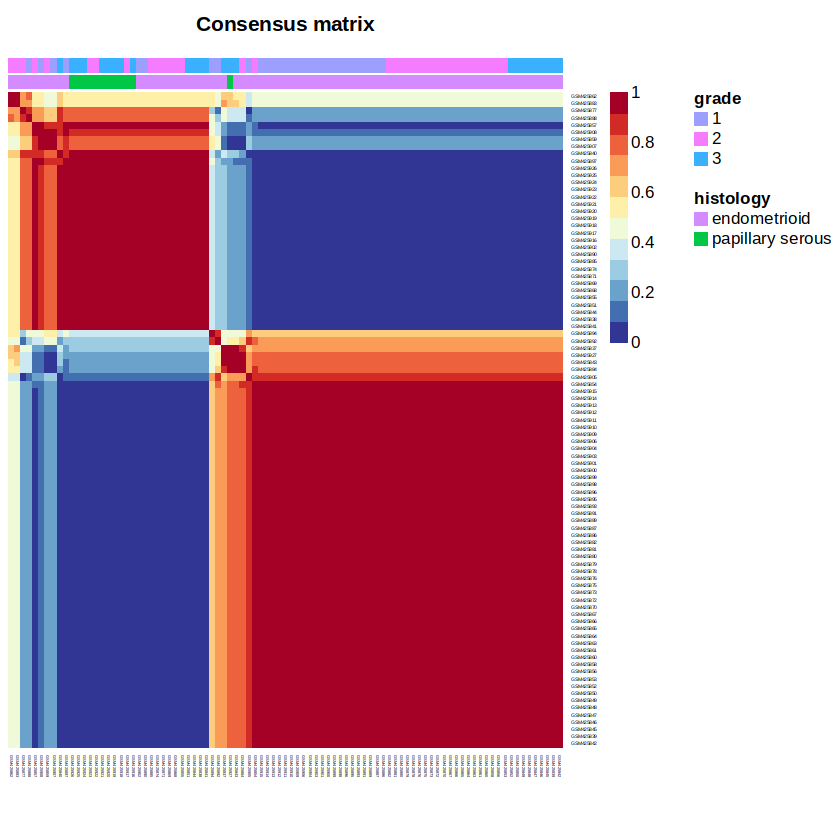

In [24]:
cp <- consensusmap(nmf_result, annCol=  merged_df[c("grade", "histology")],tracks =c(), Rowv = FALSE)

In [155]:
library("RColorBrewer")

In [ ]:
consensusmap(ucec_best_res,
        annCol=ucec_clinical_data[colnames(ucec_prim_exp_data),][c('clinical_stage', 'histological_type', 'histological_grade')],
        annRow=ucec_clinical_data[colnames(ucec_prim_exp_data),][c('clinical_stage', 'histological_type', 'histological_grade')],
        annColors = list( c("darkgreen", "blue4", "orange", "red"), rainbow(3),   brewer.pal(n = 4, name = "Set1")),
        main='', 
        tracks=c(),
        info = FALSE,
        Rowv = FALSE,
        labRow = NA,
        labCol = NA,
        #color = "Blues",
        fontsize = 14
        ) 

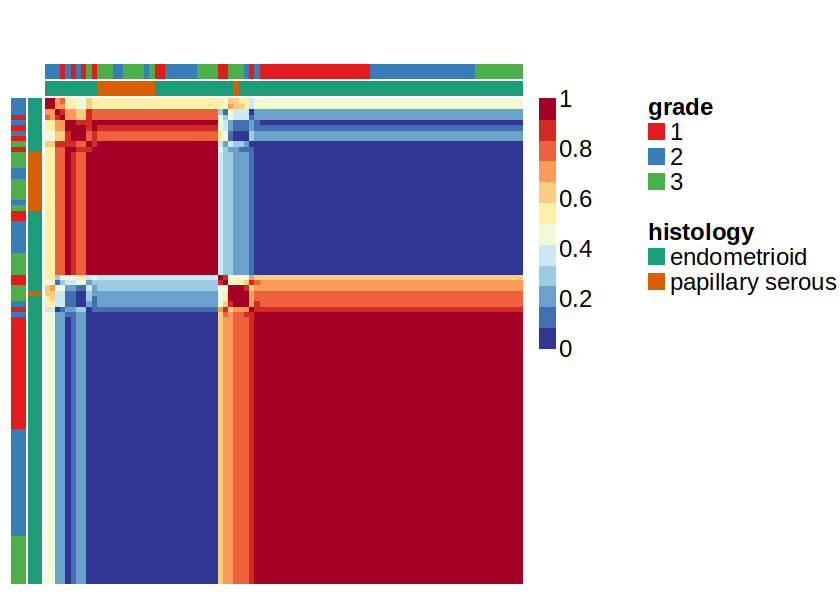

In [163]:
options(repr.plot.width = 7, repr.plot.height = 5)
consensusmap(nmf_result, 
             annCol=  merged_df[c("grade", "histology")],
             annRow=  merged_df[c("grade", "histology")],
             annColors = list( brewer.pal(n = 3, name = "Set1"), brewer.pal(n = 4, name = "Dark2")),
             main='', 
        tracks=c(),
        info = FALSE,
        Rowv = FALSE,
        labRow = NA,
        labCol = NA,
        #color = "Blues",
        fontsize = 14)

In [164]:
consensus_plot_file <- file.path(paste('validation_consensus_plot.tiff', sep=''))

# Open a PNG file - width and height arguments control the size of the output
tiff(consensus_plot_file, height = 5, width = 7, units = 'in', res=300)

# Print your heatmap
consensusmap(nmf_result, 
             annCol=  merged_df[c("grade", "histology")],
             annRow=  merged_df[c("grade", "histology")],
             annColors = list( brewer.pal(n = 3, name = "Set1"), brewer.pal(n = 4, name = "Dark2")),
             main='', 
        tracks=c(),
        info = FALSE,
        Rowv = FALSE,
        labRow = NA,
        labCol = NA,
        #color = "Blues",
        fontsize = 14)

# Close the PNG file:
dev.off()

png 
  2

In [25]:
merged_df$nmf_cluster <- NA
merged_df[lapply(cut(cp$Rowv,0.5)$lower, function(l)rapply(l,function(i) i))[[1]], "nmf_cluster"] <- "cluster_1"
merged_df[lapply(cut(cp$Rowv,0.5)$lower, function(l)rapply(l,function(i) i))[[2]], "nmf_cluster"] <- "cluster_2" 
                                                           
merged_df$subtypes <- NA
merged_df[lapply(cut(cp$Rowv,0.5)$lower, function(l)rapply(l,function(i) i))[[1]], "subtypes"] <- "Metabolic_subtype-1"
merged_df[lapply(cut(cp$Rowv,0.5)$lower, function(l)rapply(l,function(i) i))[[2]], "subtypes"] <- "Metabolic_subtype-2"
                                                           
print(dim(merged_df))
head(merged_df, 3)

[1]  91 936


,209529_at,206043_s_at,213988_s_at,229975_at,204584_at,227702_at,212249_at,209692_at,206191_at,227075_at,⋯,210029_at,206617_s_at,229241_at,203126_at,215129_at,206268_at,histology,grade,nmf_cluster,subtypes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
GSM425837,10.243531,10.26737,11.65906,11.57095,3.321928,11.984276,7.518850,11.09974,9.058533,10.62123,⋯,6.791814,4.439623,4.529821,9.316734,6.821455,10.270646,endometrioid,3,cluster_1,Metabolic_subtype-1
GSM425838,9.361066,11.28071,13.91815,12.93443,7.343408,7.291861,10.874059,11.40365,7.934281,12.29981,⋯,10.021119,2.944858,4.770829,7.440454,9.185867,6.279843,endometrioid,3,cluster_2,Metabolic_subtype-2
GSM425839,9.371777,10.78349,12.33218,12.18512,6.352264,11.212922,9.378728,12.02369,10.257152,12.46778,⋯,8.958263,4.578939,6.598425,8.174426,6.281698,10.132628,endometrioid,3,cluster_1,Metabolic_subtype-1


In [25]:
table(merged_df["nmf_cluster"])


cluster_1 cluster_2 
       58        33 

In [26]:
table(merged_df["subtypes"])


Metabolic_subtype-1 Metabolic_subtype-2 
                 58                  33 

In [27]:
table(merged_df[c("nmf_cluster", "histology")])

           histology
nmf_cluster endometrioid papillary serous
  cluster_1           57                1
  cluster_2           22               11

In [28]:
table(merged_df[c("nmf_cluster", "grade")])

           grade
nmf_cluster  1  2  3
  cluster_1 24 22 12
  cluster_2  6 14 13

In [29]:
get_probe_id <- function(gene_name){
    ids <- filter(probe_gene_mapping, Gene.symbol == gene_name)$ID
    return (ids)
}
get_probe_id("GLS")

[1] "221510_s_at" "203158_s_at" "203159_at"   "241034_at"   "203157_s_at"
[6] "211414_at"   "223079_s_at" "223080_at"

In [30]:
copy_merged_df <- data.frame(merged_df)
colnames(copy_merged_df) <- c(filter(mad_probes, ID %in% colnames(merged_df))$Gene.symbol, "histology",
                              "grade", "nmf_cluster")
print(dim(copy_merged_df))
head(copy_merged_df,3)

[1]  91 936


,PLPP2,ATP2C2,SAT1,BMPR1B,L1CAM,CYP4X1,PIK3R1,EYA2,ENTPD3,ELP3,⋯,IDO1,RENBP,LDHD,IMPA2,PIK3C2G,LEFTY1,histology,grade,nmf_cluster,NA
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
GSM425837,10.243531,10.26737,11.65906,11.57095,3.321928,11.984276,7.518850,11.09974,9.058533,10.62123,⋯,6.791814,4.439623,4.529821,9.316734,6.821455,10.270646,endometrioid,3,cluster_1,Metabolic_subtype-1
GSM425838,9.361066,11.28071,13.91815,12.93443,7.343408,7.291861,10.874059,11.40365,7.934281,12.29981,⋯,10.021119,2.944858,4.770829,7.440454,9.185867,6.279843,endometrioid,3,cluster_2,Metabolic_subtype-2
GSM425839,9.371777,10.78349,12.33218,12.18512,6.352264,11.212922,9.378728,12.02369,10.257152,12.46778,⋯,8.958263,4.578939,6.598425,8.174426,6.281698,10.132628,endometrioid,3,cluster_1,Metabolic_subtype-1


### Boxplot

In [31]:
gene_interest1 <- c("GLS", "ASS1", "PNMT", "ERBB2", "GLDC", "PSAT1", "SULT1E1", "UGT1A1",
                  "UGT3A1", "CYP1A2", "BHMT", "CBS", "TKTL1")
print(length(gene_interest1))

[1] 13


In [33]:
gene_intersect <- intersect(gene_interest1, colnames(copy_merged_df))
boxplot_df <- stack(copy_merged_df[gene_intersect])
boxplot_df$grade <- rep(copy_merged_df$grade, length(gene_intersect))
boxplot_df$nmf_cluster <- rep(copy_merged_df$nmf_cluster, length(gene_intersect))
boxplot_df$histology <- rep(copy_merged_df$histology, length(gene_intersect))
colnames(boxplot_df) = c("normalised_expression", "Genes", "grade", "nmf_cluster", "histology")
print(dim(boxplot_df))
head(boxplot_df, 4)

[1] 455   5


,normalised_expression,Genes,grade,nmf_cluster,histology
,<dbl>,<fct>,<chr>,<chr>,<chr>
1,9.776926,ASS1,3,cluster_1,endometrioid
2,10.462298,ASS1,3,cluster_2,endometrioid
3,11.900037,ASS1,3,cluster_1,endometrioid
4,8.880808,ASS1,3,cluster_2,endometrioid


In [34]:
gene_intersect

[1] "ASS1"  "PNMT"  "GLDC"  "PSAT1" "CBS"

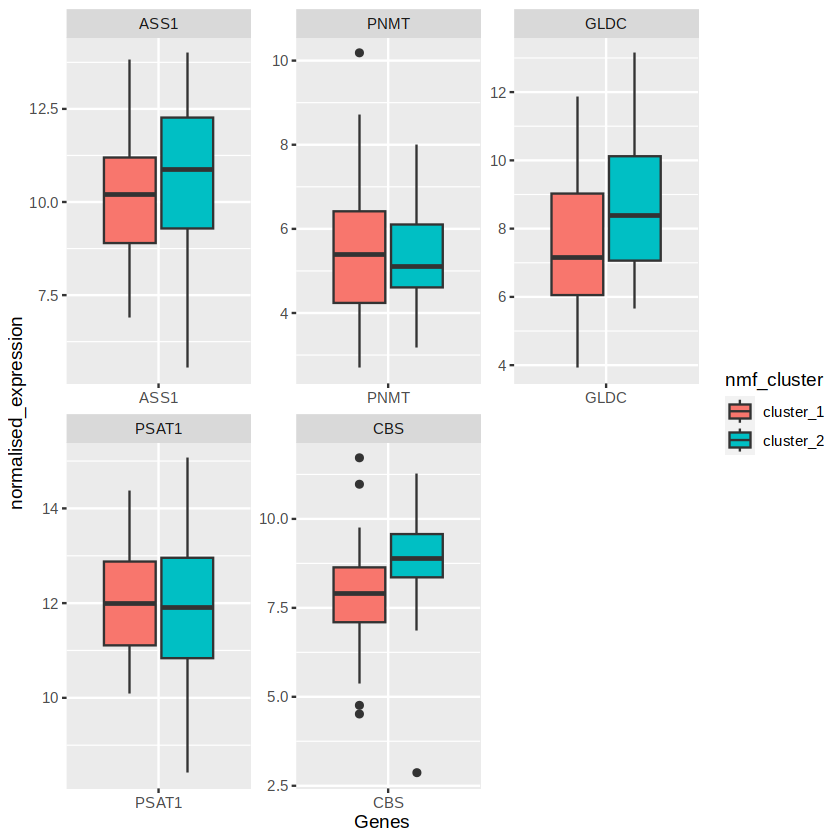

In [35]:
ggplot(boxplot_df, aes(x= Genes, y = normalised_expression, fill = nmf_cluster)) + geom_boxplot() +
facet_wrap(~Genes, scale="free")

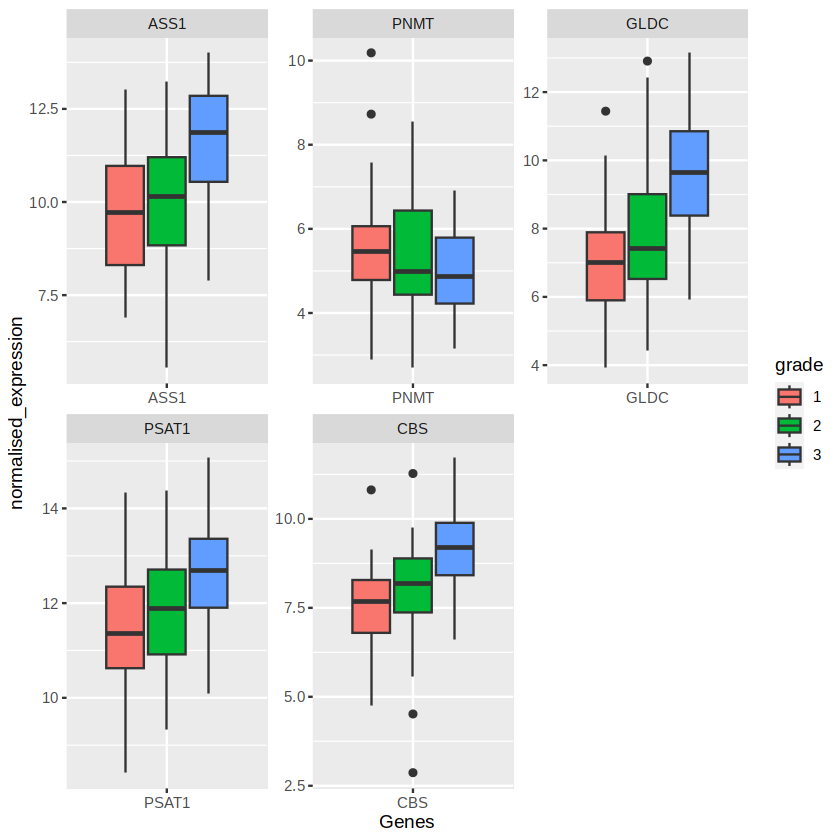

In [36]:
ggplot(boxplot_df, aes(x= Genes, y = normalised_expression, fill = grade)) + geom_boxplot() +
facet_wrap(~Genes, scale="free")

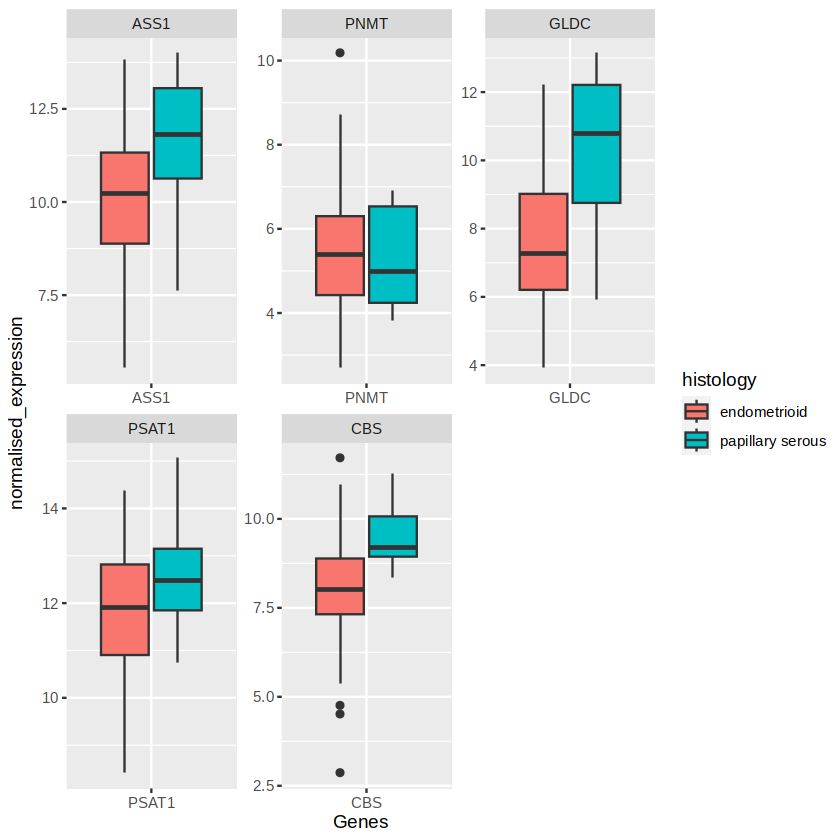

In [37]:
ggplot(boxplot_df, aes(x= Genes, y = normalised_expression, fill = histology)) + geom_boxplot() +
facet_wrap(~Genes, scale="free")

In [38]:
#heatmap(as.matrix(t(copy_merged_df[, intersect(gene_interest1, colnames(copy_merged_df)) ])), )

## DEGs-limma

In [39]:
# set up design matrix
design <- model.matrix(~nmf_cluster+0, merged_df["nmf_cluster"])
colnames(design) <- c("cluster_1", "cluster_2")
print(dim(design))
head(design)

[1] 91  2


,cluster_1,cluster_2
GSM425837,1,0
GSM425838,0,1
GSM425839,1,0
GSM425840,0,1
GSM425841,0,1
GSM425842,1,0


In [40]:
limma_exp_df <- tumor_exp[filter(probe_gene_mapping, Gene.symbol %in% hmr2_genes )$ID,]
print(dim(limma_exp_df))
head(limma_exp_df, 3)

[1] 8041   91


,GSM425837,GSM425838,GSM425839,GSM425840,GSM425841,GSM425842,GSM425843,GSM425844,GSM425845,GSM425846,⋯,GSM425918,GSM425919,GSM425920,GSM425921,GSM425922,GSM425923,GSM425924,GSM425925,GSM425926,GSM425927
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
219408_at,7.316508,9.598983,7.735387,9.546702,7.512543,9.409179,9.616916,6.272397,8.873752,7.950702,⋯,3.523562,8.338068,6.889960,4.217231,7.047669,7.452035,4.292782,7.531381,7.791814,8.361066
213198_at,11.368070,11.182767,11.466637,11.422170,11.261155,10.920725,11.132243,12.882108,11.672072,11.227435,⋯,12.073472,12.829941,12.422170,13.524346,13.793410,12.839538,13.090195,13.277956,13.125639,11.842547
206043_s_at,10.267372,11.280713,10.783489,7.314697,7.352264,10.431915,7.643135,7.797662,8.253138,8.393605,⋯,7.578939,6.498251,3.232661,8.040564,5.520422,8.584587,6.503031,3.217231,5.472488,6.298292


In [41]:
# fit linear model
fit <- lmFit(limma_exp_df, design)  

In [42]:
# set up contrasts of interest and recalculate model coefficients
cts <- c(paste("cluster_2","-", "cluster_1",sep=""))
cont.matrix <- makeContrasts(contrasts=cts, levels=design)
fit2 <- contrasts.fit(fit, cont.matrix)

# compute statistics and table of top significant genes
fit2 <- eBayes(fit2, 0.01)

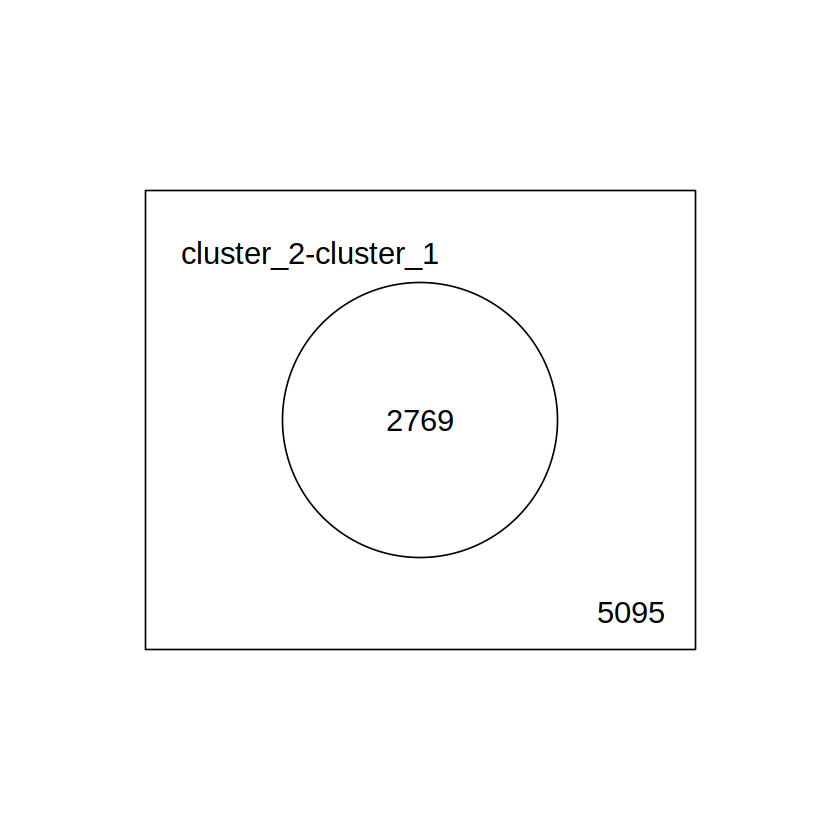

In [43]:
results <- decideTests(fit2, p.value=0.05)
vennDiagram(results) 

In [44]:
summary(results)

       cluster_2-cluster_1
Down                  1133
NotSig                5095
Up                    1636

In [45]:
table(results)

results
  -1    0    1 
1133 5095 1636 

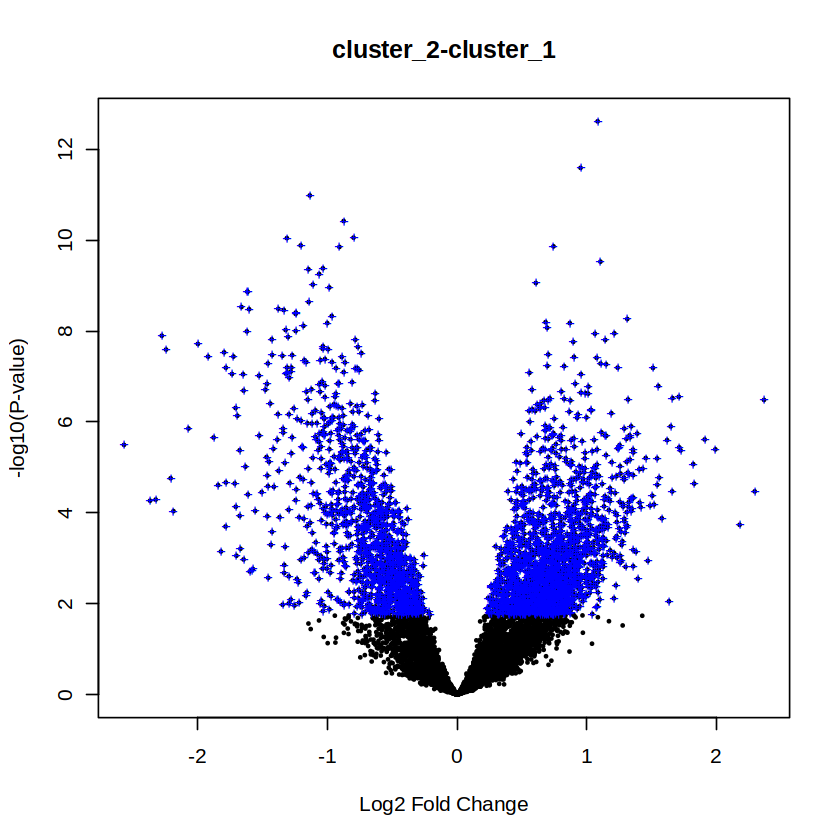

In [46]:
ct <- 1
volcanoplot(fit2, coef=ct, main=colnames(fit2)[ct], pch=20,
  highlight=length(which(results[,ct]!=0)), names=rep('+', nrow(fit2)))

In [47]:
# table of  significant genes (adj-p-value < 0.05)
sig_genes_res <- topTable(fit2,  number= 2769)
sig_genes_res <- merge(sig_genes_res, probe_gene_mapping,  by = "row.names")
rownames(sig_genes_res) <- sig_genes_res$Row.names
sig_genes_res$Row.names <- NULL
dim(sig_genes_res)
head(sig_genes_res, 4)
# write.table(tT, file=stdout(), row.names=F, sep="\t")

[1] 2769    8

,logFC,AveExpr,t,P.Value,adj.P.Val,B,ID,Gene.symbol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1494_f_at,0.6008067,7.119589,3.618259,0.0004813752,0.00354783,-0.3955357,1494_f_at,CYP2A6
1552256_a_at,0.3460136,9.260924,2.686417,0.0085501408,0.02914534,-2.9957263,1552256_a_at,SCARB1
1552263_at,0.3965639,8.250964,2.444023,0.0164036513,0.04733883,-3.5661541,1552263_at,MAPK1
1552279_a_at,0.4738966,7.769054,2.998921,0.0034731256,0.01478758,-2.1932345,1552279_a_at,SLC46A1


In [48]:
length(unique(sig_genes_res$Gene.symbol))

[1] 1917

In [49]:
unq_sig_genes_res <- data.frame()
for (gene in unique(sig_genes_res$Gene.symbol)){
    #print(gene)
    temp_df <- filter(sig_genes_res, Gene.symbol == gene )
    #print(dim(temp_df)[1])
    if (dim(temp_df)[1] == 1){
        unq_sig_genes_res <- rbind(unq_sig_genes_res, temp_df)
    }
    else{
        unq_sig_genes_res <- rbind(unq_sig_genes_res, temp_df[which.min(temp_df$adj.P.Val),])
    }
}

print(dim(unq_sig_genes_res))
head(unq_sig_genes_res,4)

[1] 1917    8


,logFC,AveExpr,t,P.Value,adj.P.Val,B,ID,Gene.symbol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1494_f_at,0.6008067,7.119589,3.618259,4.813752e-04,0.0035478300,-0.3955357,1494_f_at,CYP2A6
201819_at,0.4354352,8.470899,3.217521,1.778246e-03,0.0090162010,-1.5890596,201819_at,SCARB1
224620_at,1.1788257,4.521299,4.400176,2.871339e-05,0.0004626589,2.2210926,224620_at,MAPK1
1552279_a_at,0.4738966,7.769054,2.998921,3.473126e-03,0.0147875799,-2.1932345,1552279_a_at,SLC46A1


In [50]:
up_genes <- filter(unq_sig_genes_res, logFC> 0)
print(dim(up_genes))

down_genes <- filter(unq_sig_genes_res, logFC < 0)
print(dim(down_genes))

[1] 1110    8
[1] 807   8


In [51]:
intersect(unq_sig_genes_res$Gene.symbol, gene_interest1)

[1] "CBS"    "GLS"    "GLDC"   "BHMT"   "CYP1A2" "ERBB2"  "TKTL1"  "UGT3A1"

In [52]:
intersect(up_genes$Gene.symbol, gene_interest1)

[1] "CBS"    "GLS"    "GLDC"   "BHMT"   "CYP1A2" "ERBB2"  "TKTL1"  "UGT3A1"

In [53]:
intersect(down_genes$Gene.symbol, gene_interest1)

character(0)

In [54]:
print_genes <- function(lst_genes){
    for (i in lst_genes){
        cat(noquote(i), sep='\n')
    }
}

In [55]:
# print_genes(up_genes$Gene.symbol)
# print_genes(down_genes$Gene.symbol)
# print_genes(filter(up_genes, logFC>0.5)$Gene.symbol)
# print_genes(filter(down_genes, abs(logFC)>0.5)$Gene.symbol)
# print_genes(filter(up_genes, abs(logFC)>0.6)$Gene.symbol)
# print_genes(filter(down_genes, abs(logFC)>0.6)$Gene.symbol)

In [153]:
length(filter(up_genes, abs(logFC)>0.6)$Gene.symbol)

[1] 777

In [56]:
length(filter(down_genes, abs(logFC)>0.6)$Gene.symbol)

[1] 493

## Boxplot

In [57]:
filter(unq_sig_genes_res, Gene.symbol %in% intersect(unq_sig_genes_res$Gene.symbol, gene_interest1))

,logFC,AveExpr,t,P.Value,adj.P.Val,B,ID,Gene.symbol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
240517_at,0.8791163,5.244814,5.016528,2.503240e-06,8.067622e-05,4.51278758,240517_at,CBS
203158_s_at,0.8481077,7.155073,3.765244,2.908472e-04,2.441102e-03,0.06857915,203158_s_at,GLS
204836_at,1.2090183,8.018082,2.728320,7.607082e-03,2.677802e-02,-2.89243572,204836_at,GLDC
206119_at,1.1196249,4.950799,3.878723,1.954288e-04,1.814465e-03,0.43607968,206119_at,BHMT
207608_x_at,0.7262206,7.799681,4.884679,4.279462e-06,1.172602e-04,4.00759031,207608_x_at,CYP1A2
210930_s_at,0.8173186,3.845954,2.907762,4.548430e-03,1.804943e-02,-2.43491654,210930_s_at,ERBB2
214183_s_at,1.5579827,4.586334,4.538986,1.683182e-05,3.189528e-04,2.72111875,214183_s_at,TKTL1
235904_at,1.0547064,4.712446,2.990634,3.560160e-03,1.503604e-02,-2.21545694,235904_at,UGT3A1


In [58]:
gene_interest2 <- c("GCK", "TKTL1", "GLDC", "AGXT", "BHMT","ERBB2", "CBS", "GLS", "CYP1A2", "ELOVL2",
                   "UGT3A1", "SLC38A1")
gi2_res <- filter(unq_sig_genes_res, Gene.symbol %in% intersect(unq_sig_genes_res$Gene.symbol, gene_interest2))
gi2_res

,logFC,AveExpr,t,P.Value,adj.P.Val,B,ID,Gene.symbol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
240517_at,0.8791163,5.244814,5.016528,2.503240e-06,8.067622e-05,4.51278758,240517_at,CBS
203158_s_at,0.8481077,7.155073,3.765244,2.908472e-04,2.441102e-03,0.06857915,203158_s_at,GLS
204836_at,1.2090183,8.018082,2.728320,7.607082e-03,2.677802e-02,-2.89243572,204836_at,GLDC
206119_at,1.1196249,4.950799,3.878723,1.954288e-04,1.814465e-03,0.43607968,206119_at,BHMT
207608_x_at,0.7262206,7.799681,4.884679,4.279462e-06,1.172602e-04,4.00759031,207608_x_at,CYP1A2
210326_at,0.6000565,3.870023,2.511744,1.373179e-02,4.137410e-02,-3.41149209,210326_at,AGXT
210930_s_at,0.8173186,3.845954,2.907762,4.548430e-03,1.804943e-02,-2.43491654,210930_s_at,ERBB2
211167_s_at,0.9208252,4.254033,3.561599,5.825616e-04,4.047053e-03,-0.57076747,211167_s_at,GCK
213712_at,0.8617724,5.177936,2.655861,9.303506e-03,3.106699e-02,-3.07018900,213712_at,ELOVL2


In [60]:
gi2_exp_pheno_df <- merge(as.data.frame(t(limma_exp_df[rownames(gi2_res),])), 
                          merged_df[c("histology","grade", "nmf_cluster", "subtypes")], 
                         by = 'row.names', all = FALSE )
rownames(gi2_exp_pheno_df) <- gi2_exp_pheno_df$Row.names
gi2_exp_pheno_df$Row.names <- NULL
colnames(gi2_exp_pheno_df) <- c(gene_interest2, "histology","grade", "nmf_cluster", "subtypes")
print(dim(gi2_exp_pheno_df))
head(gi2_exp_pheno_df, 5)

[1] 91 16


,GCK,TKTL1,GLDC,AGXT,BHMT,ERBB2,CBS,GLS,CYP1A2,ELOVL2,UGT3A1,SLC38A1,histology,grade,nmf_cluster,subtypes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
GSM425837,5.116864,6.925999,9.678776,5.708739,7.083213,3.153805,4.426265,3.981853,5.332708,4.336283,4.300124,4.008989,endometrioid,3,cluster_1,Metabolic_subtype-1
GSM425838,5.498251,7.658211,6.551516,5.017922,8.521993,4.371559,5.013462,6.856737,5.439623,3.954196,2.744161,6.656782,endometrioid,3,cluster_2,Metabolic_subtype-2
GSM425839,4.683696,7.851124,8.448736,6.491853,7.416164,3.053111,4.026800,4.061776,6.366322,2.786596,5.840463,2.321928,endometrioid,3,cluster_1,Metabolic_subtype-1
GSM425840,5.189825,7.872829,8.575161,5.617651,7.675957,2.678072,2.887525,3.548437,5.296457,3.643856,3.321928,5.529821,endometrioid,3,cluster_2,Metabolic_subtype-2
GSM425841,6.581954,8.023477,10.120627,7.246028,8.370251,5.837943,7.215290,5.736064,6.407693,6.446256,3.536053,7.569856,endometrioid,3,cluster_2,Metabolic_subtype-2


In [138]:
boxplot_df2 <- stack(gi2_exp_pheno_df[gene_interest2])
boxplot_df2$grade <- rep(gi2_exp_pheno_df$grade, length(gene_interest2))
boxplot_df2$nmf_cluster <- rep(gi2_exp_pheno_df$nmf_cluster, length(gene_interest2))
boxplot_df2$subtypes <- rep(gi2_exp_pheno_df$subtypes, length(gene_interest2))
boxplot_df2$histology <- rep(gi2_exp_pheno_df$histology, length(gene_interest2))
colnames(boxplot_df2) = c("Normalized_expression", "Genes", "grade", "nmf_cluster", "subtypes", "histology")
print(dim(boxplot_df2))
head(boxplot_df2, 4)

[1] 1092    6


,Normalized_expression,Genes,grade,nmf_cluster,subtypes,histology
,<dbl>,<fct>,<chr>,<chr>,<chr>,<chr>
1,5.116864,GCK,3,cluster_1,Metabolic_subtype-1,endometrioid
2,5.498251,GCK,3,cluster_2,Metabolic_subtype-2,endometrioid
3,4.683696,GCK,3,cluster_1,Metabolic_subtype-1,endometrioid
4,5.189825,GCK,3,cluster_2,Metabolic_subtype-2,endometrioid


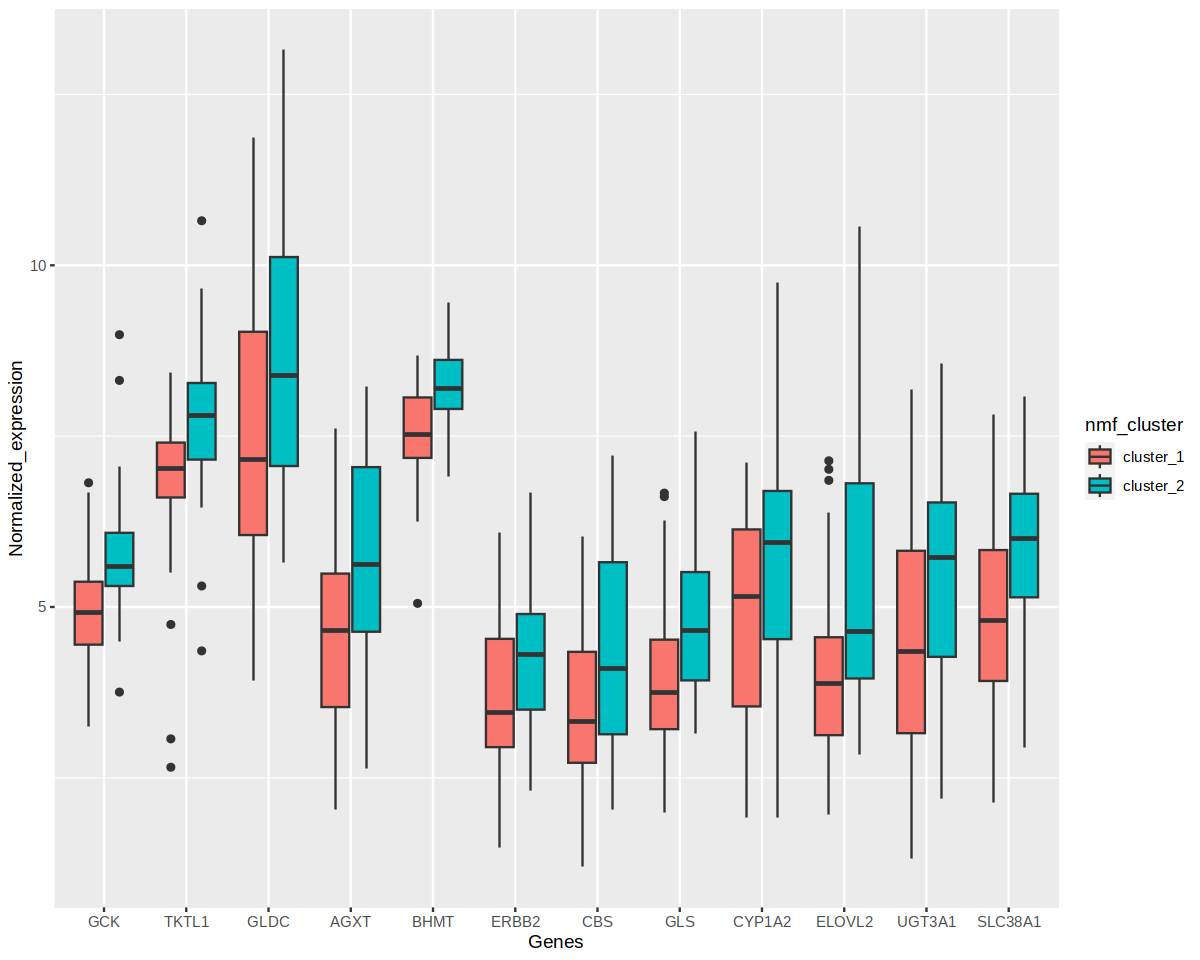

In [139]:
ggplot(boxplot_df2, aes(x= Genes, y = Normalized_expression, fill = nmf_cluster)) + geom_boxplot()

In [69]:
library(tidyverse)
library(repr)

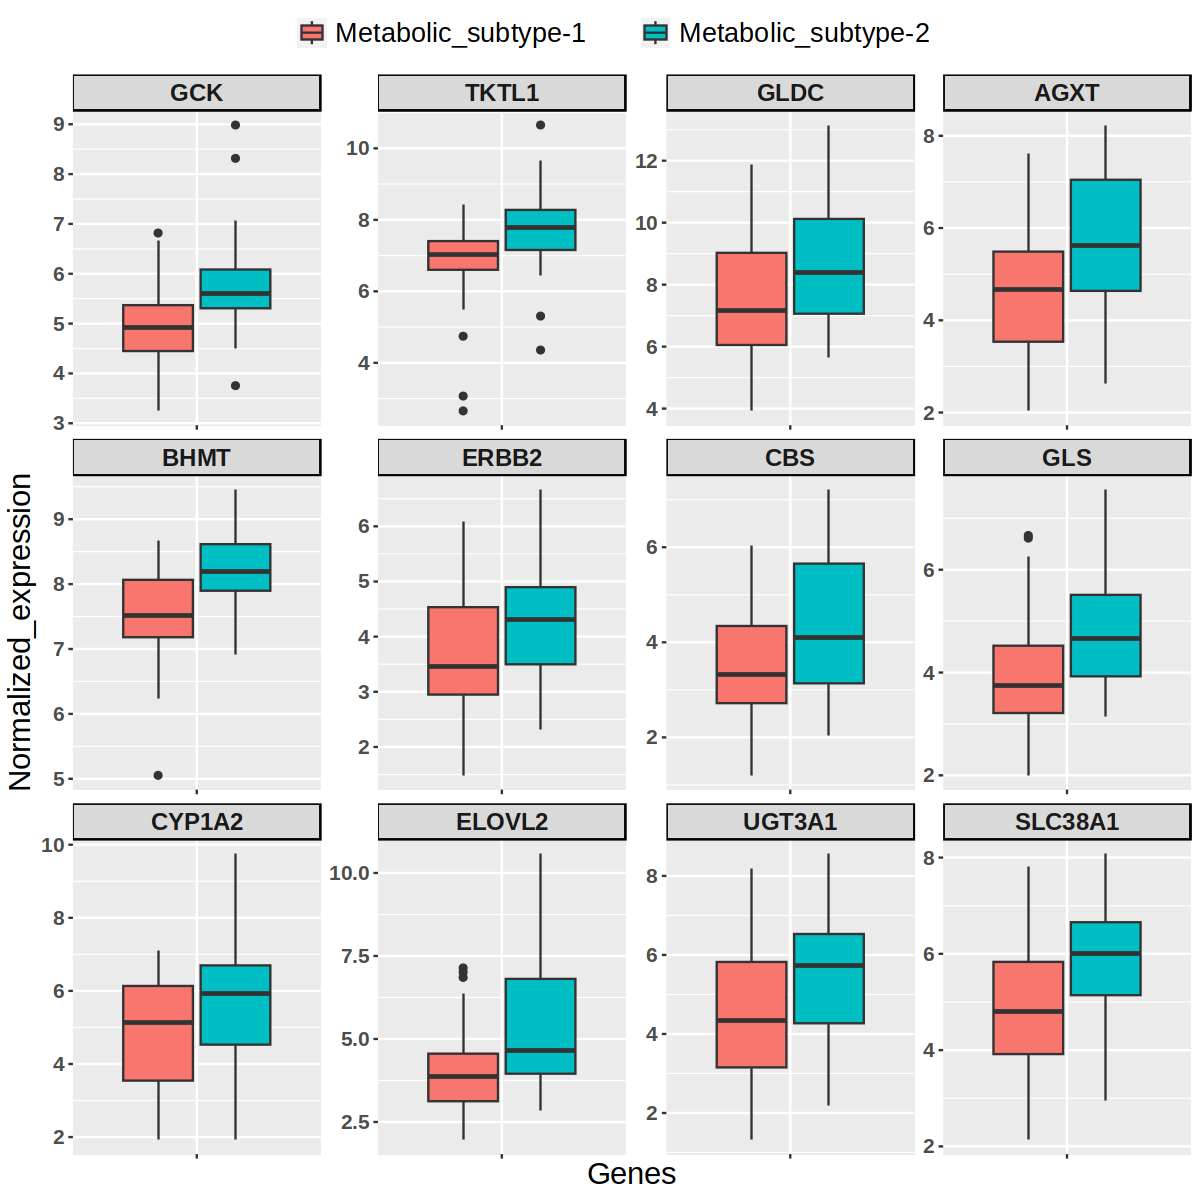

In [148]:
options(repr.plot.width = 10, repr.plot.height = 10 )
ggplot(boxplot_df2, aes(x= Genes, y = Normalized_expression, fill = subtypes)) + geom_boxplot() +
facet_wrap(~Genes, scale="free") +
theme(
    strip.text = element_text(face = "bold", size = 14),
    strip.background = element_rect(colour = "black", size = 0.6),
    axis.text.x.bottom = element_blank(),
    legend.title=element_blank(),
    axis.text = element_text(face="bold", size = 12),
    legend.text = element_text( size = 16, margin = margin(r = 30, unit = "pt")),
    legend.position="top",
    axis.title = element_text(size = 18)
  ) 

In [152]:
boxplot_plot_file <- file.path(paste( 'Boxplot-GSE17025-upDEGS_revision.tiff', sep =''))

# Open a PNG file - width and height arguments control the size of the output
tiff(boxplot_plot_file, height = 8, width = 8, units = 'in', res= 300)


# Print your heatmap
ggplot(boxplot_df2, aes(x= Genes, y = Normalized_expression, fill = subtypes)) + geom_boxplot() +
facet_wrap(~Genes, scale="free") +
theme(
    strip.text = element_text(face = "bold", size = 12),
    strip.background = element_rect(colour = "black", size = 0.6),
    axis.text.x.bottom = element_blank(),
    legend.title=element_blank(),
    axis.text = element_text(face="bold", size = 12),
    legend.text = element_text( size = 16, margin = margin(r = 30, unit = "pt")),
    legend.position="top",
    axis.title = element_text(size = 18)
  ) 

# Close the PNG file:
dev.off()

png 
  2

## FIsher Exact Test

In [150]:
library(vcd)

Loading required package: grid



In [151]:
ucec_hist_type_f_test <- fisher.test(table(gi2_exp_pheno_df$histology, 
                                           gi2_exp_pheno_df$nmf_cluster))
print(ucec_hist_type_f_test)

assocstats(table(gi2_exp_pheno_df$histology, gi2_exp_pheno_df$nmf_cluster))


	Fisher's Exact Test for Count Data

data:  table(gi2_exp_pheno_df$histology, gi2_exp_pheno_df$nmf_cluster)
p-value = 3.67e-05
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
    3.618049 1238.924079
sample estimates:
odds ratio 
  27.45417 



                    X^2 df   P(> X^2)
Likelihood Ratio 18.852  1 1.4123e-05
Pearson          18.357  1 1.8314e-05

Phi-Coefficient   : 0.449 
Contingency Coeff.: 0.41 
Cramer's V        : 0.449 

In [152]:
ucec_hist_grade_f_test <- fisher.test(table(gi2_exp_pheno_df$grade, 
                                           gi2_exp_pheno_df$nmf_cluster))
print(ucec_hist_grade_f_test)

assocstats(table(gi2_exp_pheno_df$grade, gi2_exp_pheno_df$nmf_cluster))


	Fisher's Exact Test for Count Data

data:  table(gi2_exp_pheno_df$grade, gi2_exp_pheno_df$nmf_cluster)
p-value = 0.04448
alternative hypothesis: two.sided



                    X^2 df P(> X^2)
Likelihood Ratio 6.4402  2 0.039952
Pearson          6.2190  2 0.044623

Phi-Coefficient   : NA 
Contingency Coeff.: 0.253 
Cramer's V        : 0.261 